In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Simple Exponential Smoothing Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


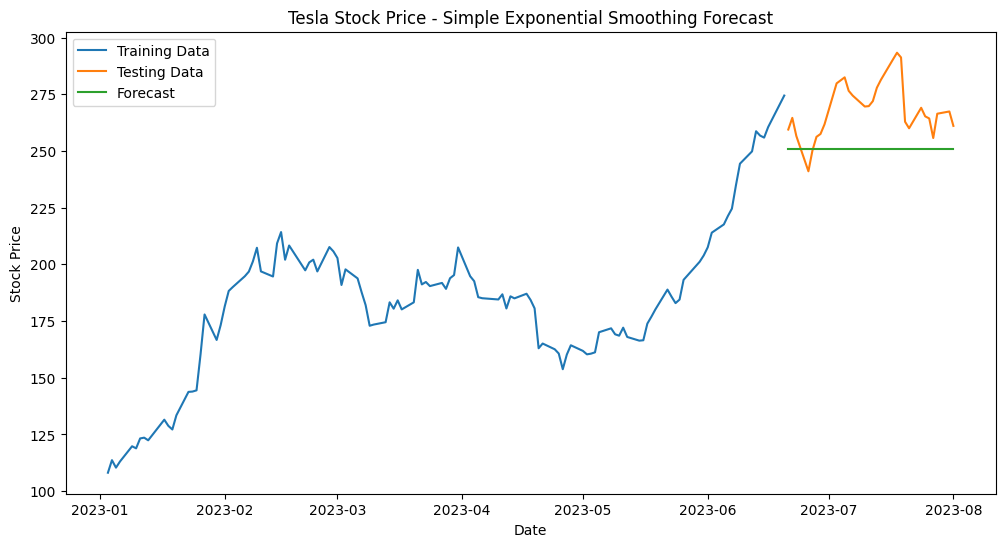

Mean Squared Error: 446.27647461937755
The forecast chart has been saved as 'tesla_forecast.png'.


In [ ]:
# Download TSLA stock data
tsla = yf.Ticker("TSLA")
data = tsla.history(start="2023-01-01", end="2023-08-02")

# Use 'Close' prices for our analysis
close_prices = data['Close']

# Split the data into training and test sets
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(train)
fit = model.fit(smoothing_level=0.2, optimized=True)

# Make predictions
forecast = fit.forecast(len(test))

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Tesla Stock Price - Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test, forecast)

print(f"Mean Squared Error: {mse}")
print("The forecast chart has been saved as 'tesla_forecast.png'.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure test and forecast are numpy arrays
test_array = test.values
forecast_array = forecast.values

# Recalculate metrics
mse = mean_squared_error(test_array, forecast_array)
mae = mean_absolute_error(test_array, forecast_array)
rmse = np.sqrt(mse)

# Calculate MAPE
mape = np.mean(np.abs((test_array - forecast_array) / test_array)) * 100

# Calculate SMAPE
smape = np.mean(200 * np.abs(forecast_array - test_array) / (np.abs(forecast_array) + np.abs(test_array)))

# Calculate MASE
mae_in_sample = np.mean(np.abs(np.diff(train.values)))
mase = mae / mae_in_sample

# R-squared and Adjusted R-squared
r_squared = r2_score(test_array, forecast_array)
n = len(test_array)
p = 1  # number of predictors
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# AIC and BIC
aic = fit.aic
bic = fit.bic

# Create summary dataframe
metrics_summary = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'],
    'Value': [mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic]
})

print("Metrics Summary:")
print(metrics_summary.to_string(index=False))

Metrics Summary:
       Metric      Value
          MSE 446.276475
          MAE  17.996224
         RMSE  21.125257
         MAPE   6.547547
        SMAPE   6.841641
         MASE   3.548212
    R_Squared  -2.007813
Adj_R_Squared  -2.119213
          AIC 614.571729
          BIC 620.078909


The walk_forward_validation method is used to evaluate the performance of an Exponential Smoothing model by making predictions and updating the model iteratively as new observations become available. This approach helps to simulate how the model would perform in a real-world scenario where you only have access to historical data up to the current point in time.

In [ ]:
import yfinance as yf
from sklearn.model_selection import train_test_split

In [ ]:
# Refactor the ARIMA code to use Exponential Smoothing instead.
# The Exponential Smoothing model will be implemented using the `statsmodels` library.

import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from IPython.display import display, HTML


class ExponentialSmoothingModel:
    def __init__(self, train, test):
        self.train = train['Close'].values
        self.test = test['Close'].values
        self.history = [x for x in self.train]
        self.predictions = []
        self.model_params = None

    # def fit_model(self):
    #     # Fit the Exponential Smoothing model
    #     model = ExponentialSmoothing(self.train, trend='add', seasonal='add', seasonal_periods=12)
    #     self.model_fit = model.fit()
    #     self.model_params = self.model_fit.params
    #     print("Model fitted with parameters:", self.model_params)
    def fit_model(self):
        # Fit the Exponential Smoothing model
        model = ExponentialSmoothing(self.train, trend='add', seasonal='add', seasonal_periods=12)
        self.model_fit = model.fit()
        self.model_params = self.model_fit.params
        # Display the model parameters in a table
        params_df = pd.DataFrame(self.model_params.items(), columns=['Parameter', 'Value'])
        display(HTML(params_df.to_html(index=False)))

    def exponential_smoothing_forecast(self):
        # Forecast using the fitted model
        output = self.model_fit.forecast(steps=1)
        return output[0]

    def walk_forward_validation(self):
        self.predictions = []
        for t in range(len(self.test)):
            yhat = self.exponential_smoothing_forecast()
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            # Refit the model with the updated history
            model = ExponentialSmoothing(self.history, trend='add', seasonal='add', seasonal_periods=12)
            self.model_fit = model.fit()

        self.calculate_metrics()

    def calculate_metrics(self):
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((self.test - self.predictions) / self.test)) * 100

        print('MSE:', mse)
        print('MAE:', mae)
        print('RMSE:', rmse)
        print('MAPE:', mape, '%')

    def plot_results(self):
        plt.figure(figsize=(12, 6), dpi=100)
        plt.plot(range(len(self.train)), self.train, color='blue', label='Training Data')
        plt.plot(range(len(self.train), len(self.train) + len(self.test)), self.test, color='green', label='Actual Data')
        plt.plot(range(len(self.train), len(self.train) + len(self.test)), self.predictions, color='red', linestyle='dashed', label='Forecasted Data')
        plt.title('Exponential Smoothing Predictions vs Actual Values')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

print("Exponential Smoothing model code refactored successfully.")

Exponential Smoothing model code refactored successfully.


In [ ]:
# Load the TSLA.csv dataset
import pandas as pd

# tsla_df = pd.read_csv('TSLA.csv')
tsla_df = pd.read_csv('tsla_.csv')
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])

# Split the data into training and testing sets
train_size = int(len(tsla_df) * 0.8)
train, test = tsla_df[:train_size], tsla_df[train_size:]


In [ ]:
# # Define the stock name
# stock_name = 'TSLA'

# # Download the data
# start_date = '2023-01-01'
# end_date = '2023-04-30'
# df = yf.download(stock_name, start=start_date, end=end_date)

# # Split the data into 80/20
# train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
# Test the Exponential Smoothing model on the TSLA.csv dataset

# Initialize the model
model = ExponentialSmoothingModel(train, test)

In [ ]:
# Fit the model
model.fit_model()

Parameter,Value
smoothing_level,1.0
smoothing_trend,0.0
smoothing_seasonal,0.0
damping_trend,NaN
initial_level,1.541692
initial_trend,0.010298
initial_seasons,"[0.040673551736118634, 0.02931210898655217, 0.0402410303555524, 0.020197152526333022, 0.025357180874197943, 0.006297981864364763, -0.00935763167252252, 0.007955696643959623, 0.05066810850729008, 0.049308091184371454, 0.014760178936531445, 0.04513010966830541]"
use_boxcox,False
lamda,None
remove_bias,False


In [ ]:
# Perform walk-forward validation
model.walk_forward_validation()

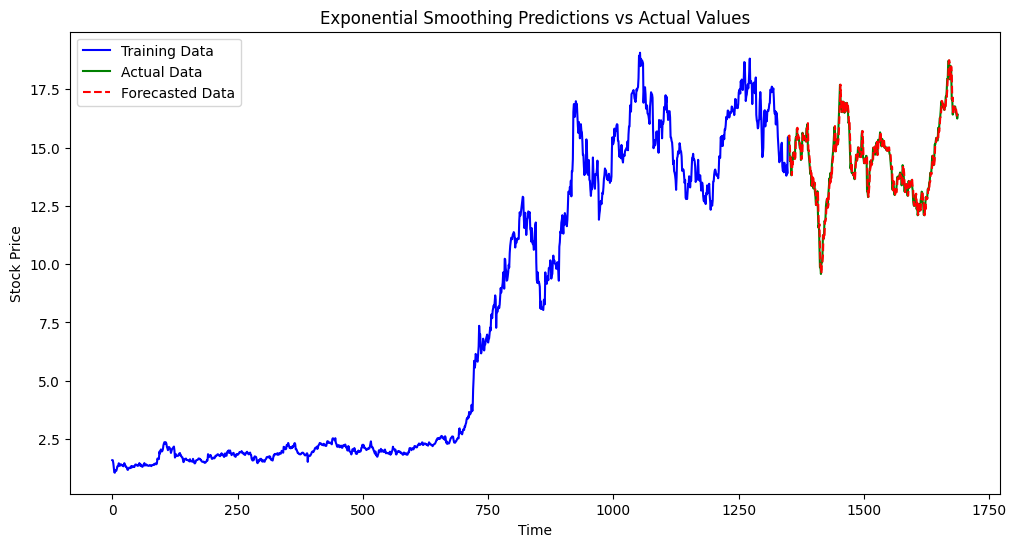

In [ ]:
# Plot the results
model.plot_results()